In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from modflow_models import transport_model
from utils import map_values_to_domain

In [2]:
idomain = np.genfromtxt("./input_data/idomain.txt", delimiter='\t')

total_times = 3650 + 1

K = np.load("./output/results_K.npy")
porosity = np.load("./output/results_porosity.npy")
results = np.load("./output/results.npy")

K = map_values_to_domain(K, idomain, fill_value=np.nan)
porosity = map_values_to_domain(porosity, idomain, fill_value=np.nan)

results_new = np.empty([total_times, 19, 100, 400])
for i in range(19):
    results_new[:, i] = map_values_to_domain(results[:, i], idomain, fill_value=np.nan)
results = results_new

MemoryError: Unable to allocate 20.7 GiB for an array with shape (3651, 19, 100, 400) and data type float64

In [3]:
import flopy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sim = flopy.mf6.MFSimulation.load(sim_name='model', sim_ws="./simulation/", exe_name='mf6', verbosity_level=0)
gwf = sim.get_model("gwf_model")
bud = sim.get_model("gwf_model").output.budget()  # 不需要手动给文件名

spdis = bud.get_data(text='DATA-SPDIS')[0]  # dict，包含 'q': ndarray

# 得到三个方向的比速分量 array，shape=(nlay, nrow, ncol)
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
porosity = 0.30
# # 如果想要孔隙水速，就除以 porosity
vx = qx / porosity
vy = qy / porosity
vz = qz / porosity

In [4]:
times = 3650

head = gwf.oc.output.head().get_alldata().reshape(times, 100, 400)
head[head == 1e30] = np.nan
head[head == -1e30] = np.nan

gwt_Cl = sim.get_model("gwt_Cl_model")
Cl = gwt_Cl.oc.output.concentration().get_alldata().reshape(times, 100, 400)
Cl[Cl == 1e30] = np.nan
Cl[Cl == -1e30] = np.nan


gwt_K = sim.get_model("gwt_K_model")
K_ = gwt_K.oc.output.concentration().get_alldata().reshape(times, 100, 400)
K_[K_ == 1e30] = np.nan
K_[K_ == -1e30] = np.nan


gwt_Na = sim.get_model("gwt_Na_model")
Na = gwt_Na.oc.output.concentration().get_alldata().reshape(times, 100, 400)
Na[Na == 1e30] = np.nan
Na[Na == -1e30] = np.nan

gwt_Density = sim.get_model("gwt_Density")
Density = gwt_Density.oc.output.concentration().get_alldata().reshape(times, 100, 400)
Density[Density == 1e30] = np.nan
Density[Density == -1e30] = np.nan

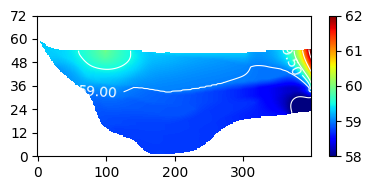

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# head[head < 58] = np.nan
time = 500

fig, ax = plt.subplots(figsize=(4,2))
im = ax.imshow(head[time], cmap="jet", aspect="auto", vmax=62, vmin=58)  
plt.colorbar(im, ax=ax)

specific_levels = [58, 59, 59.5, 60, 61, 62]
contours = ax.contour(
    head[time],
    # levels=10,          # 仍然指定要画多少条线
    colors="white",
    linewidths=0.8,
    levels=specific_levels,
)
ax.clabel(contours, inline=True, fontsize=10, fmt="%.2f", colors="white")

yticks = ax.get_yticks()
max_pos = yticks.max()

# 反向映射：max_pos → 0，0 → 60
new_labels = [f"{((max_pos - y) / max_pos * 60):.0f}" for y in yticks]


ax.set_yticks(yticks)
ax.set_yticklabels(new_labels)

plt.tight_layout()
plt.show()


In [11]:
# import numpy as np

# # 原始参数
# nlay = 100

# top = 60.0
# thickness = 0.6
# botm_list = (np.linspace(top - thickness, 0.0, num=nlay)).tolist()

# botm_list[10] = botm_list[10] - (4.2 - 0.6) # 让第11层厚度变为4.2m
# del botm_list[11:17] # 移除被合并的6层(原12-17层)
# botm_final = np.array(botm_list)
# nlay_final = len(botm_final)
# # --- 核心修改代码结束 ---

# # 将最终的列表转为Numpy数组，并更新层数


# # 检查一下结果
# print(f"新的总层数: {nlay_final}")
# print(f"原始第10层底板: {botm_list[9]:.2f}")
# print(f"新的第11层(索引10)顶板: {botm_list[9]:.2f}")
# print(f"新的第11层(索引10)底板: {botm_final[10]:.2f}")
# print(f"新的第11层厚度: {botm_list[9] - botm_final[10]:.2f} m") 
# print(f"新的第12层(索引11)底板: {botm_final[11]:.2f}")

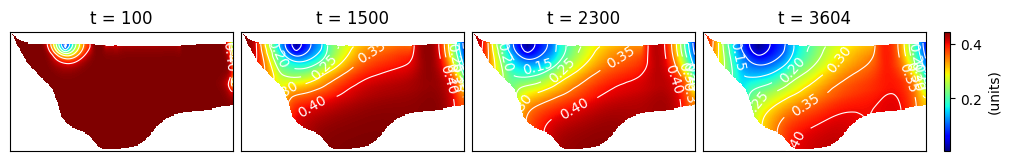

In [18]:
import matplotlib.pyplot as plt

# 要画的四个时刻的索引
times = [100, 1500, 2300, 3604]    # 第20天，第60天，第80天，以及最后一个时刻
n = len(times)

fig, axes = plt.subplots(1, n, figsize=(10, 1.5), constrained_layout=True)

# 遍历每个子图
for ax, t in zip(axes, times):
    ob = K_[t, :, :]
    im = ax.imshow(ob, cmap="jet", aspect="auto")  # , vmax=0.35, vmin=0.0
    
    # 叠加等高线
    contours = ax.contour(ob, levels=8, colors="white", linewidths=0.8)
    ax.clabel(contours, inline=True, fontsize=10, fmt="%.2f", colors="white")
    
    # 标题标注时间
    ax.set_title(f"t = {t}")
    
    ax.set_xticks([])
    ax.set_yticks([])

# 在右侧加一个共享的 colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("(units)")

plt.show()


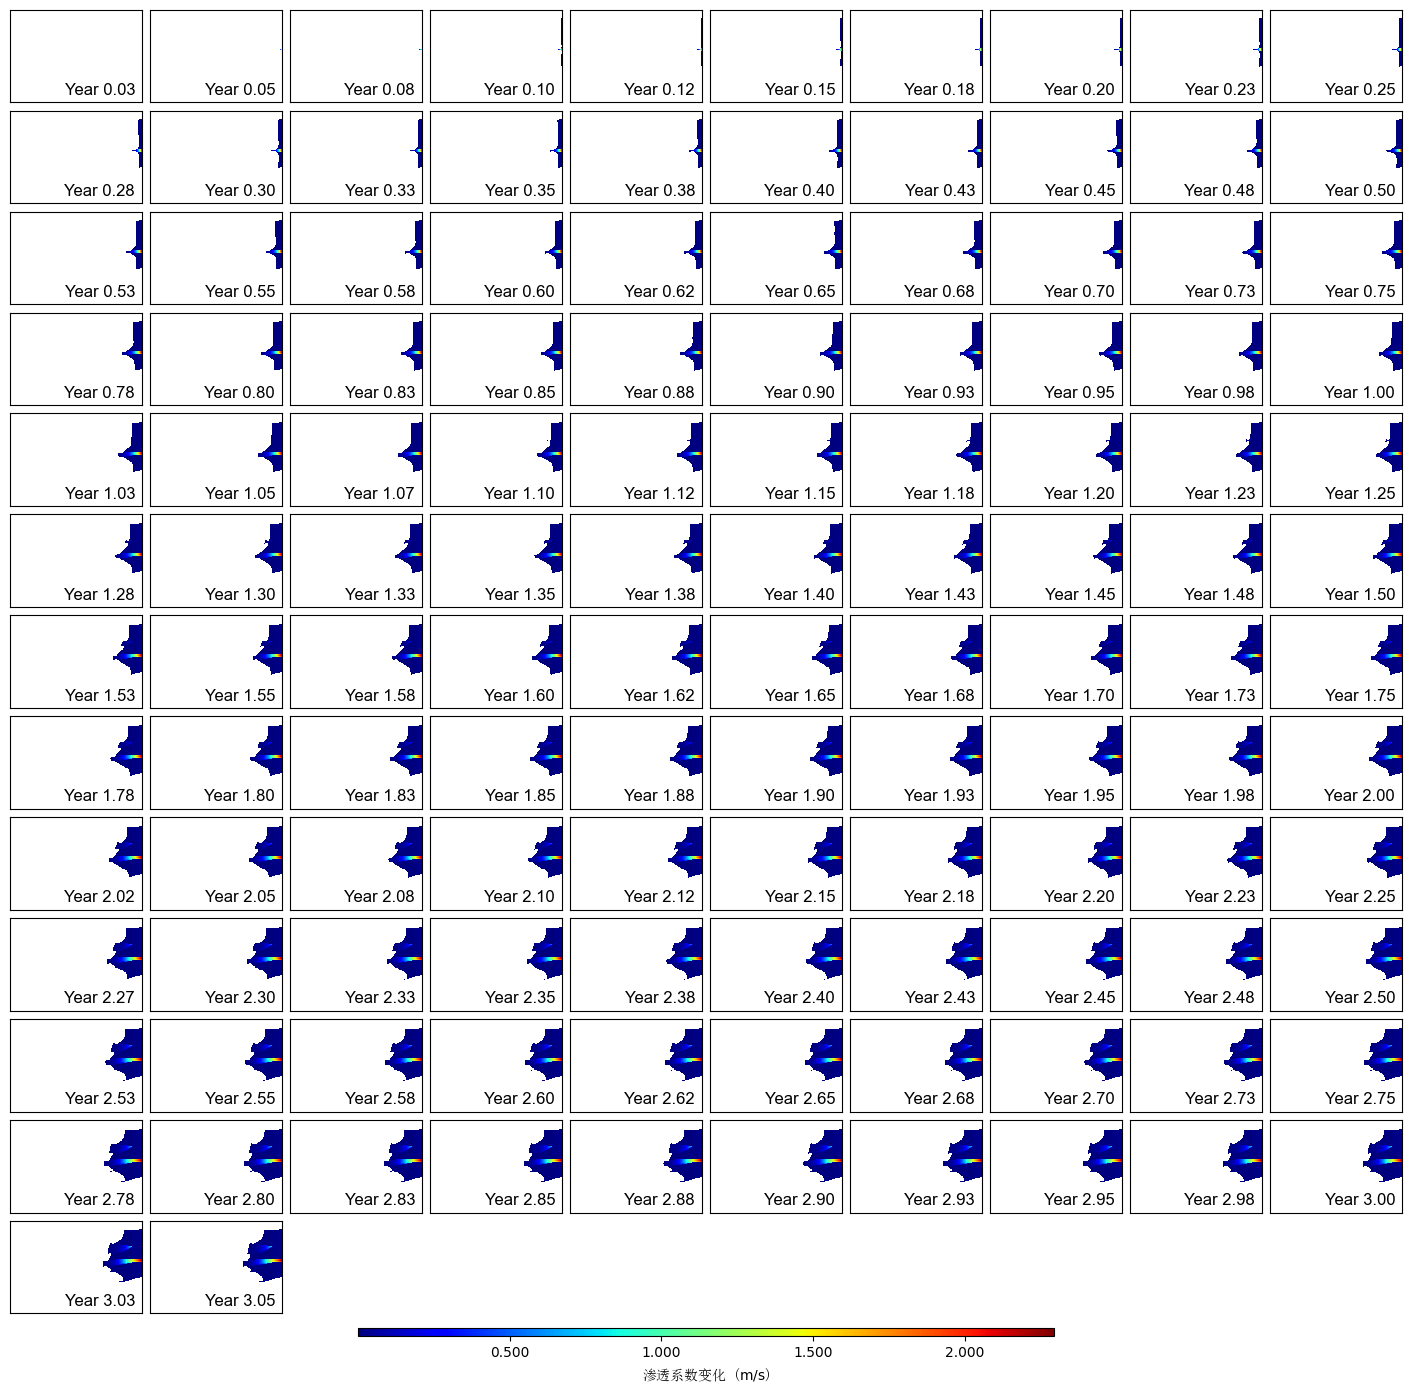

In [7]:
# K_base = K
data_to_plot_percent = [(K[i, :, :] - K[0, :, :])  for i in range(1, total_times-1, 3)] # / K[0, :, :] * 100
# data_to_plot_percent = [(results[i, 9, :, :]) for i in range(1, total_times, 3)] # / K_base[0, :, :] * 100 -K_base[0, :, :]
# data_to_plot_percent = [(n[i, :, :] - n[0, :, :]) / n[0, :, :] * 100 for i in range(1, total_times, 1)]

# --- 对数处理的关键步骤 ---
# a. 处理非正值：将 <= 0 的值 mask 掉
data_to_plot_log = []
for arr_percent in data_to_plot_percent:
    # 构造掩码：值 <=0 或 <1e-3 的都设为 True（表示被 mask）
    mask = (arr_percent <= 0) | (arr_percent < 1e-4)
    masked_arr = np.ma.array(arr_percent, mask=mask)
    data_to_plot_log.append(masked_arr)

# b. 重新计算全局 vmin 和 vmax (只考虑未被 mask 的正值)
#    确保 vmin 是一个小的正数，vmax 是最大值
all_positive_values = np.concatenate([arr.compressed() for arr in data_to_plot_log])
log_vmin = np.min(all_positive_values)
log_vmax = np.max(all_positive_values)
if log_vmin < 1e-4: # 可以根据需要调整这个阈值
    log_vmin = 1e-4

# print(log_vmin)
# print(log_vmax)
log_vmin = np.nanmin(data_to_plot_percent)
log_vmax = np.nanmax(data_to_plot_percent)

n_rows, n_cols = 24, 10
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(14, 24),
    constrained_layout=True    # <— 打开 constrained_layout
)
axes = axes.flatten()
time_points = list(range(1, total_times, 1))
# 绘图循环
for idx, arr_log in enumerate(data_to_plot_log):
    ax = axes[idx]
    norm = LogNorm(vmin=log_vmin, vmax=log_vmax)
    mappable = ax.imshow(arr_log, cmap="jet", aspect='auto') # norm=norm, 
    # ax.set_title(f'K[{idx*2+1}] - K[0] (%)')
    ax.set_xticks([])
    ax.set_yticks([])

    # 计算当前时刻对应的“年”
    t = time_points[idx]       # 原始时刻编号：1,3,5,...
    year = t * (3.0/120)         # 0–9→1年；10–19→2年；20–29→3年

    # 在坐标轴的右下角添加文本
    ax.text(
        0.95, 0.05,      # 坐标轴内位置 (x, y)，右下角
        f'Year {year:.2f}',
        transform=ax.transAxes,
        fontdict={'family': 'Arial'},
        ha='right', va='bottom',
        fontsize=12,
        # color='white',
    )

# 删除多余的子轴
for ax in axes[len(data_to_plot_log):]:
    fig.delaxes(ax)

# 放 colorbar
cbar = fig.colorbar(
    mappable,
    ax=axes[:len(data_to_plot_log)].tolist(),
    location='bottom',
    pad=0.01,
    aspect=80,
    format='%.3f',
    shrink=0.5
)

cbar.set_label(r'渗透系数变化 ($\mathrm{m/s}$)', fontdict={'family': 'SimSun'})
# cbar.set_label(r'孔隙度变化比率 ($\mathrm{\%}$)', fontdict={'family': 'SimSun'})

plt.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from modflow_models import transport_model

import os
import numpy as np
import traceback
import phreeqcrm
import modflowapi
import sys

from mf6pqc.mf6pqc import mf6pqc
from modflow_models import transport_model

head, concentration_data = transport_model(
    sim_ws='./simulation',
    species_list=["Ca", "Mg", "Cl"],
    perlen=1095,
    nstp=120,
    initial_conc=np.ones(120000) * 0.05,
    bc=[0.1, 0.1, 0.1],
    porosity=0.30,
    K11=1.0,
    initial_density=1000.0,
    initial_head=100.0
)

plt.imshow(head.reshape(-1, 100, 400)[-1])
plt.show()